# 2.1 はじめに
確率ロボティクスの核心：センサデータから**状態推定**する

**状態推定** - 推論できるが直接観測できない値をセンサデータから推定する問題

- 2.2節 : 確率の概念
- 2.3節 : ロボットと環境の相互作用に対する我々の形式モデル
- 2.4節 : ベイズフィルタ
- 2.5節 : ベイズフィルタ実装の際の数式表現上，計算上の問題

# 2.2 確率の基本的な概念

# 2.3 ロボットと環境の相互作用
**環境** - 内部状態を保つ力学系
- ロボットは自身のセンサを用いて環境の情報を取得するが，雑音を被る
- 直接知覚することができない物も多く存在
- 自身のアクチュエータを通じて環境に影響を与える

→ 環境の状態に関する内部信念を維持・更新，制御動作が環境状態とロボットの内部信念に影響

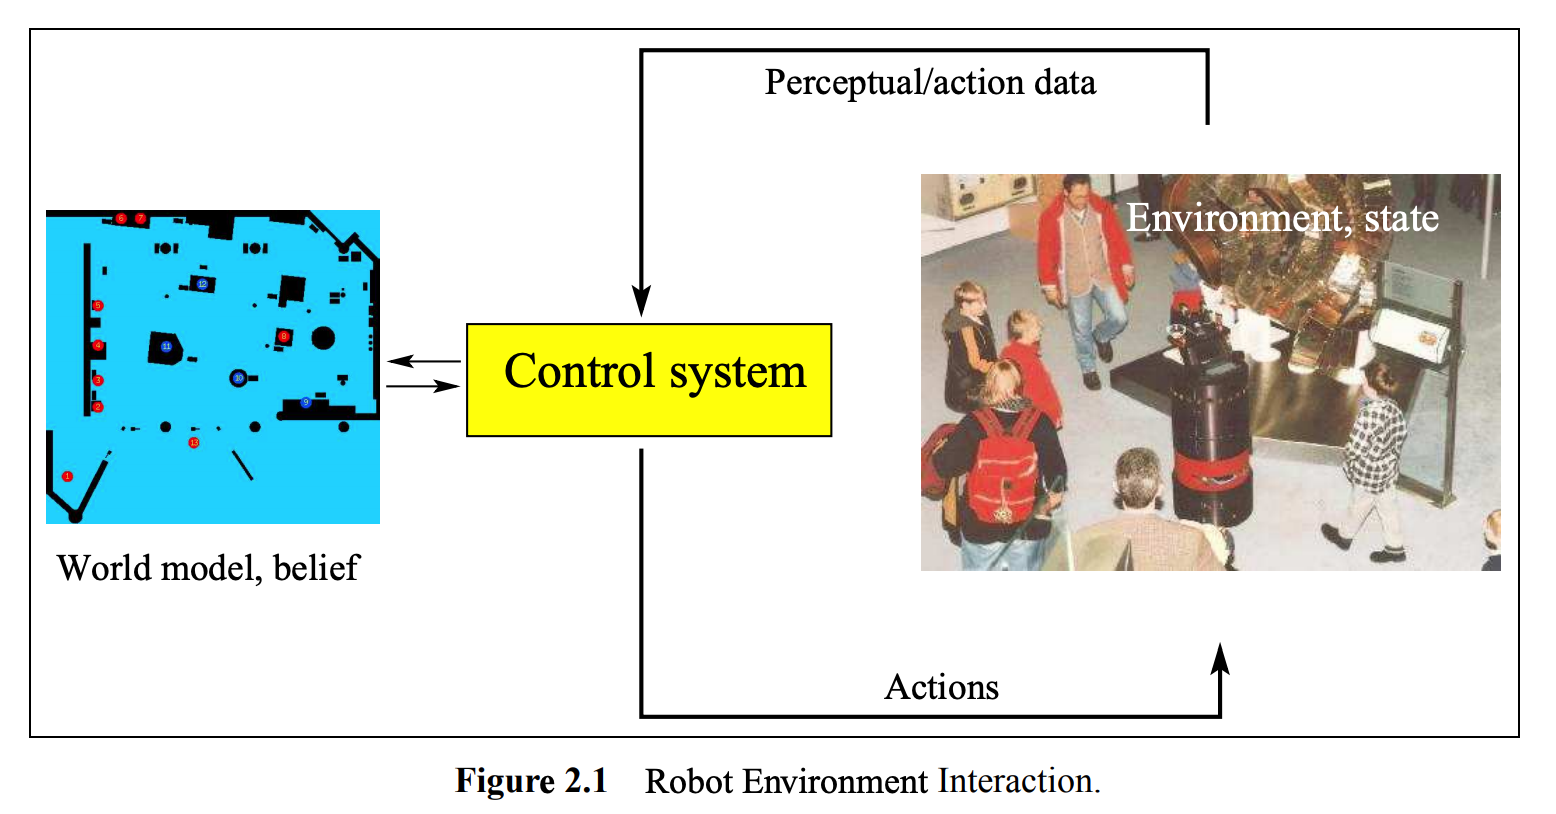

In [1]:
from IPython.display import Image, display_png
png_file = 'fig/text/fig2_1.png'
display_png(Image(png_file, width=500))

## 2.3.1 状態
ロボットと環境の，将来に影響する全ての局面として**状態**$x$(時刻$t$の状態$x_t$)を考える
- **動的状態** - 時間経過とともに変化 (i.g. ロボットの近くにいる人々)
- **静的状態** - 時間経過とともに変化しない (i.g. 建物の壁)


- ロボットの**姿勢** - グローバル座標系に対するロボットの位置，向きの6変数 
- **アクチュエータのコンフィギュレーション** - 回転ジョイントの関節角など，運動学的状態
- **ロボットの速度と関節の速度** - 力学的状態，6個の速度変数
- **環境中の物体の位置と特徴** 
- **移動物体と人の位置**
- センサが壊れているかどうか，電池の残量などなど


**完備** - 状態$x_t$が将来を予測するために最善なもの

**マルコフ連鎖** - 将来の状態は確率的に遷移するが，将来に影響を与える変数が$x_t$の他にないこと

**不完備状態** - 完備な状態ベクトルから変数を抜き取った状態ベクトル；環境中全ての状態を考慮することは不可能だから，現実的な実装では不完備状態を扱う

## 2.3.2 環境との相互作用
下記の2種類の相互作用が同時に起こる
- 環境のセンサ計測 - **観測**，**知覚**；センサの計測値は少し前の時刻の状態に関する情報
- 制御動作 - ロボットの移動やマニピュレーションなどで環境に能動的に力を加えることで状態を変化させる

センサ計測値や制御動作の記録(**データ**)も2種類存在する
- 環境計測データ $z_{t_1:t_2} = z_{t_1}, z_{t_1+1}, z_{t_1+2}, \cdots,  z_{t_2}$
- 制御データ $u_{t_1:t_2} = u_{t_1},u_{t_1+1}, u_{t_1+2}, \cdots,  u_{t_2}$

環境認識はロボットの知識を増やす傾向，行動は知識の損失を起こす傾向

行動と知覚は同時に起こるが，便宜上，分けて考える

## 2.3.3 確率的発生(生成)法則
- ロボットが制御動作$u_1$を行ってから計測$z_1$を行うと仮定
- 一般に，状態$x_t$は状態$x_{t-1}$から確率的に発生する

状態$x_t$は過去の全ての状態や計測値，制御に従属されているように思われる $p(x_t|x_{0:t-1}, z_{1:t-1}, u_{1:t})$

状態$x$が完備ならば$x$には過去に起こった全てのことが集約されるから，もし状態$x_{t-1}$が分かっていれば$u_t$のみが問題となる(条件付き独立性)
$$
\begin{align}
p(x_t|x_{0:t-1}, z_{1:t-1}, u_{1:t}) = p(x_t|x_{t-1}, u_{t}) \tag{2.31}
\end{align}
$$
計測モデルも条件付き独立性から
$$
\begin{align}
p(z_t|x_{0:t-1}, z_{1:t-1}, u_{1:t}) = p(z_t|x_{t}) \tag{2.32}
\end{align}
$$

- 状態遷移確率$p(x_t|x_{t-1}, u_{t})$ : ロボットの制御$u_t$によってどのように環境の状態が時間発展するかを規定する確率分布
- 計測確率$p(z_t|x_{t})$ : 環境の状態$x$からどの計測値$z$が得られるかということに関する確率分布，ノイズが混ざる
- 状態遷移確率と計測確率が一体となってロボットとその環境に対する確率力学系を表現する
- Fig2.2 : 時刻$t$の状態$x_t$は時刻$t-1$の状態$x_{t-1}$と制御$u_t$に依存している
    - **隠れマルコフモデル(HMM)，ダイナミックベイズネットワーク(DBN)**

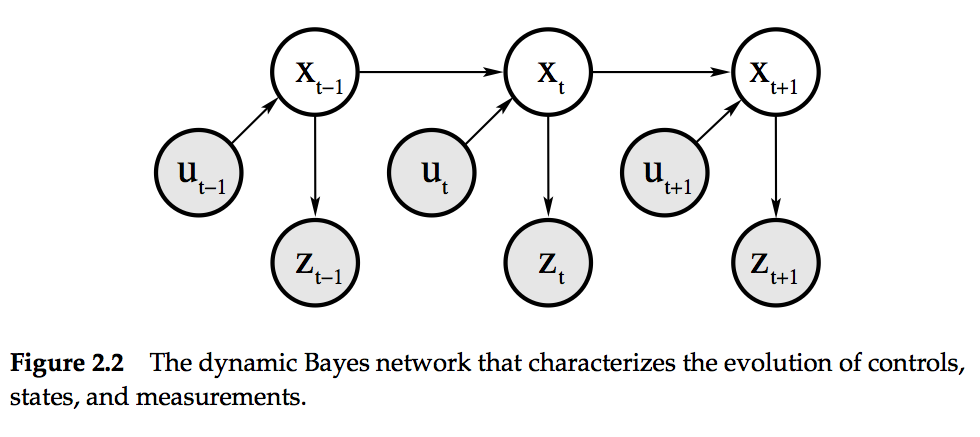

In [2]:
png_file = 'fig/text/fig2_2.png'
display_png(Image(png_file, width=500))

## 2.3.4 信念分布
- **信念** - 環境の状態に関するロボットの内部知識を反映するもの，**状態の知識**，**情報状態**(?)
- (**客観的(頻度論的な)な確率分布ではなく，ロボットから見た主観的な確率分布**)
- 状態変数で構成される空間上で定義される
- 得られたデータで条件付ける
- あり得る全ての仮説に確率が割り振られた事後確率分布
- ある状態の定義$x_t$上の事後信念$bel(x_t)$
$$
\begin{align}
bel(x_t) = p(x_t|z_{1:t}, u_{1:t}) \tag{2.33}
\end{align}
$$
- 制御$u_t$を実行した**直後**，$z_t$を反映する**前**の事後信念(**予測分布**)$\overline{bel}(x_t)$
$$
\begin{align}
\overline{bel}(x_t) = p(x_t|z_{1:t-1}, u_{1:t}) \tag{2.33}
\end{align}
$$
- $\overline{bel}(x_t)$から$bel(x_t)$を計算することを**修正**もしくは**計測更新**という

# 2.4 ベイズフィルタ

## 2.4.1 ベイズフィルタアルゴリズム
- **ベイズフィルタ** - 計測や制御データから信念確率分布$bel$を計算するアルゴリズム
- Tabel2.1 : ベイズフィルタの擬似コード
- $bel(x_{t-1})$から$bel(x_t)$が計算される再帰計算
- 分かっているのは，遷移確率$p(x_t|x_{t-1}, u_{t})$，計測確率$p(z_t|x_{t})$，前時間stepの$bel(x_{t-1})=p(x_{t-1}|z_{1:t-1}, u_{1:t-1})$，時刻$t$の制御$u_t$，計測$z_t$
- 3行目 : **予測分布**(制御$u_t$を実行した**直後**，$z_t$を反映する**前**) 
    - (時刻$t-1$から$t$への状態遷移確率の，時刻$t-1$での信念の下での$x_{t-1}$に関する期待値と解釈できる(?))
$$
\begin{align}
\overline{bel}(x_t) &= p(x_t|z_{1:t-1}, u_{1:t}) \\
& = \int p(x_t, x_{t-1}|z_{1:t-1}, u_t, u_{1:t-1}) dx_{t-1} \\
& = \int p(x_t|u_t, x_{t-1}) p(x_{t-1}|z_{1:t-1}, u_{1:t-1}) dx_{t-1} \\
&= \int p(x_t|u_t, x_{t-1}) bel(x_{t-1})dx_{t-1} \\
&= \mathbb{E}_{x_{t-1} \sim bel(x_{t-1})} \left[ p(x_t|u_t, x_{t-1}) \right]
\end{align}
$$
- 4行目 : **計測更新**($z_t$を反映)
    - 予測分布を事前分布，状態遷移確率を尤度としてベイズの定理から事後分布$bel(x_t)$が求まる
$$
\begin{align}
bel(x_t) &= p(x_t|z_{1:t}, u_{1:t}) \\
& = p(x_t|z_t, z_{1:t-1}, u_{1:t})  \\
&= \frac{p(z_t|x_{t}) p(x_t|z_{1:t-1}, u_{1:t})}{p(z_t)} \\
&= \frac{p(z_t|x_{t}) \overline{bel}(x_t)}{\int p(z_t|x_{t}) \overline{bel}(x_t) dx_t} \\
&= \eta p(z_t|x_{t}) \overline{bel}(x_t)
\end{align}
$$
- 反復演算には初期信念$bel(x_0)$が必要
    - 初期条件$x_0$が既知：$x_0$に確率密度が集中した確率分布
    - 初期条件$x_0$が未知：一様分布(あるいはディリクレ分布)

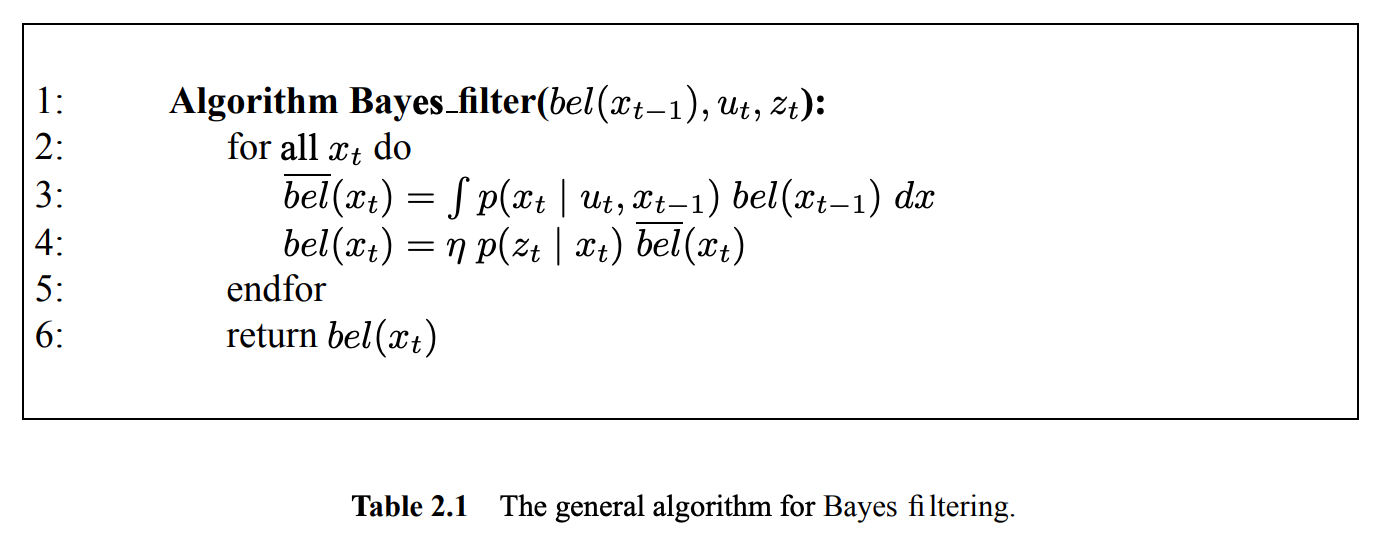

In [5]:
png_file = 'fig/text/tab2_1.png'
display_png(Image(png_file, width=750))

## 2.4.2 例
略

## 2.4.3 ベイズフィルタの数学的導出
#### 2.4.1で述べちゃった

## 2.4.4 マルコフ性
**マルコフ性** - 現在の状態$x_t$が既知ならば過去や未来のデータが独立していることを要求する仮定


次の要因はマルコフ性に反する
- $x_t$に含まれない環境中の，モデル化されないダイナミクス
- 計測確率や状態遷移確率といった確率モデルが不正確
- 信念を関数近似した時の近似誤差
- ロボット制御ソフトウェア内の，複数の制御に影響を与えるソフトウェア変数

不完備な状態は，より複雑な状態表現よりも，ベイズフィルタアルゴリズムの計算複雑性を減らす

ベイズフィルタはマルコフ性の破れに対して驚くほどロバスト

モデル化されない状態変数の影響がほぼ変量効果(平均値ゼロでランダム)を持つように注意すべき

# 2.5 表現と計算
